In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.8 # np. indexing error on version above
      !pip install lavavu-osmesa==1.8.32 geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
# import the oris and datas
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

In [6]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

# Add Boulder-Lefroy

In [7]:
BL_pts = gpd.read_file(os.path.join(path_shp, "BL_pts_elevation_2.shp"))
BL_pts = pd.DataFrame({'X': BL_pts.geometry.x, 
              'Y': BL_pts.geometry.y, 
              'Z': BL_pts.DEM_main})

BL_pts['fault_name'] = "Boulder Lefroy Fault"

In [8]:
BL_seismic = gpd.read_file(os.path.join(path_seismic, "Boulder_Lefroy_cropped.shp"))

BL_seismic = BL_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
BL_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

BL_seismic['fault_name'] = BL_seismic['fault_name'].str.replace('Boulder-Lefroy Shear Zone', "Boulder Lefroy Fault")

# drop the values above zero
BL_seismic = BL_seismic.drop(BL_seismic[BL_seismic['Z']>0].index)

In [9]:
gs = []

tmpA = []
tmpB = []

xs = BL_seismic['X'].to_numpy()
ys = BL_seismic['Y'].to_numpy()
zs = BL_seismic['Z'].to_numpy()

meanX = BL_pts['X'].mean()
meanY = BL_pts['Y'].mean()
meanZ = zs.mean() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Boulder Lefroy Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [10]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [11]:
updated_data = pd.concat([updated_data, BL_seismic, BL_pts])

In [12]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularisation = [5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])


model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 29.50869059562683 seconds


In [13]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])


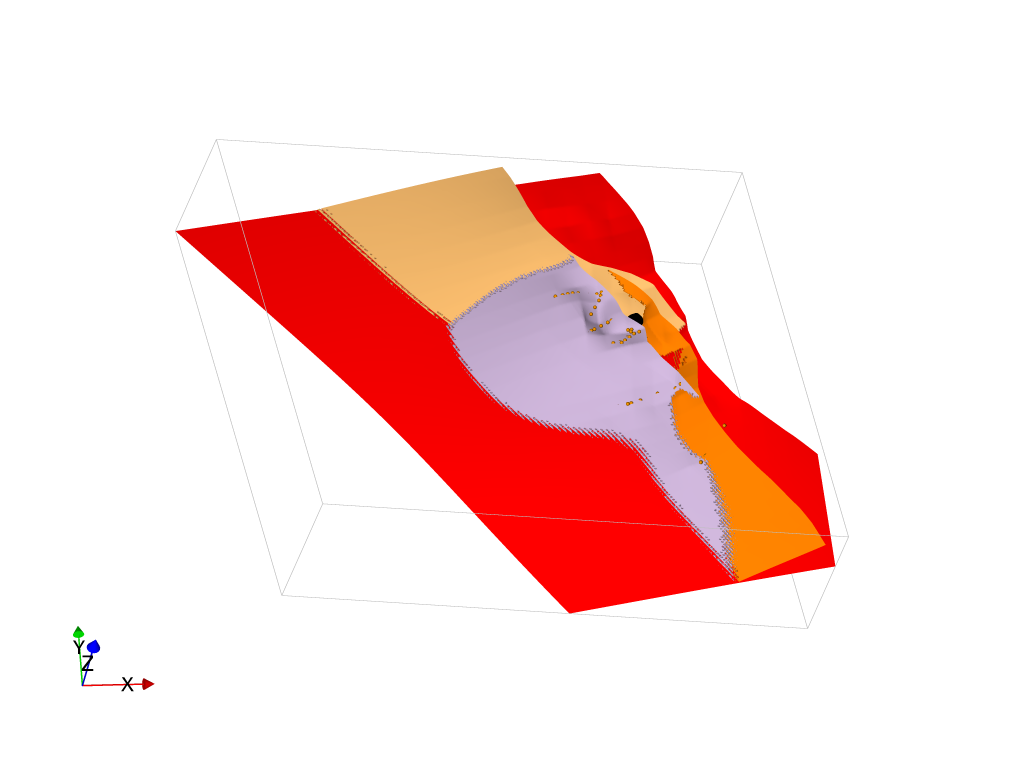

In [14]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)
# view.add_isosurface(model['Abattoir West Fault'], colours = ['#ffff99'], value = 0)
# view.add_isosurface(model['Abattoir East Fault'], colours = ['b15928'], value = 0)

# view.add_points(BL_seismic[['X', 'Y', 'Z']], pointsize = 2, name = 'x')

view.add_data(model['Boulder Lefroy Fault'][0], )
# view.add_data(model['Kanowna Fault'][0])

view.add_points(BL_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(AE_seismic[['X', 'Y', 'Z']], pointsize = 10, pointcolour = 'green', name = 'AE_seismic')
# view.add_points(AW_seismic[['X', 'Y', 'Z']], pointsize = 10, pointcolour = 'green', name = 'AW_seismic')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')

view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

# view.interactive()

# Add Abattoirs

In [15]:
AE_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_East_pts_elevation.shp"))
AE_pts = pd.DataFrame({'X': AE_pts.geometry.x, 
              'Y': AE_pts.geometry.y, 
              'Z': AE_pts.DEM_main})

AE_pts['fault_name'] = "Abattoir East Fault"

AE_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_East_Fault.shp"))

AE_seismic = AE_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AE_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AE_seismic['fault_name'] = AE_seismic['fault_name'].str.replace('Abattoir', "Abattoir East Fault")

gs = []

tmpA = []
tmpB = []

xs = AE_seismic['X'].to_numpy()
ys = AE_seismic['Y'].to_numpy()
zs = AE_seismic['Z'].to_numpy()

meanX = AE_pts['X'].mean()
meanY = AE_pts['Y'].mean()
meanZ = zs.max() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir East Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])
updated_data = pd.concat([updated_data, AE_pts])

In [16]:
AW_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_West_pts_elevation.shp"))
AW_pts = pd.DataFrame({'X': AW_pts.geometry.x, 
              'Y': AW_pts.geometry.y, 
              'Z': AW_pts.DEM_main})

AW_pts['fault_name'] = "Abattoir West Fault"

AW_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_West_Fault.shp"))

AW_seismic = AW_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AW_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AW_seismic['fault_name'] = AW_seismic['fault_name'].str.replace('unnamed02', "Abattoir West Fault")

gs = []

tmpA = []
tmpB = []

xs = AW_seismic['X'].to_numpy()
ys = AW_seismic['Y'].to_numpy()
zs = AW_seismic['Z'].to_numpy()

meanX = AW_pts['X'].mean()
meanY = AW_pts['Y'].mean()
meanZ = zs.max() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir West Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [17]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])

updated_data = pd.concat([updated_data, AW_pts])

In [18]:
updated_ori


,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853
1,Ida Fault,281825.127090,6.595975e+06,-19118.905000,0.455672,0.129275,0.865917
2,Bullabulling North Fault,288597.465546,6.618662e+06,-6250.689000,0.352245,0.102473,0.917071
3,Bulla_Abut_North,291113.118517,6.597520e+06,410.622447,0.000000,-0.996646,0.003071
4,Bullabulling South Fault,300390.029744,6.573092e+06,-6250.689000,0.352245,0.102473,0.917071
5,Bulla_Abut_South,298395.373188,6.581800e+06,404.589443,0.000000,0.043609,0.001308
6,Zuleika Fault,336167.443915,6.581425e+06,-3475.761250,-0.387965,-0.203100,-0.899018
7,MtMonger Fault,377066.123368,6.600121e+06,347.830000,0.380703,0.135495,-0.914716
8,Kanowna Fault,346826.424001,6.627378e+06,-6363.455172,0.199087,0.570989,-0.796452
9,Boorara Fault,360094.160551,6.592193e+06,-4751.938857,0.427567,0.191523,-0.883462


In [19]:
updated_data = updated_data.dropna()

In [20]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  
model.nsteps = [100, 100, 250]

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 1, nelements=1e4, force_mesh_geometry = False, 
                           regularisation = [5,5,5], cwp = 0.1)
# model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
# model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
# model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
#                            cpw = 0.2, regularisation = [5, 5, 5])

# model.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
# model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 3.9466519355773926 seconds



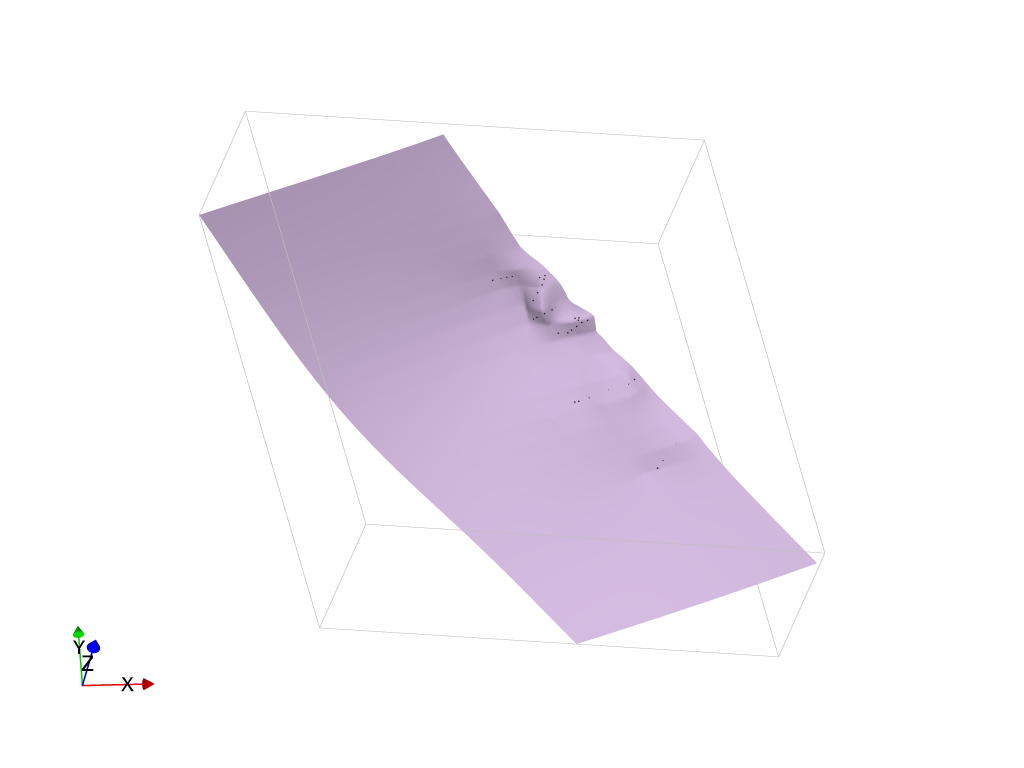

In [21]:
view = LavaVuModelViewer(model)

view.nelements = 4e6

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
# view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
# view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
# view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)
# view.add_isosurface(model['Abattoir West Fault'], colours = ['#ffff99'], value = 0)
# view.add_isosurface(model['Abattoir East Fault'], colours = ['b15928'], value = 0)

view.add_points(BL_seismic[['X', 'Y', 'Z']], pointsize = 2, name = 'BoulderL seismic')

# view.add_data(model['Boulder Lefroy Fault'][0], )
# view.add_data(model['Kanowna Fault'][0])

view.add_points(BL_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'BoulderL surface')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, colour = 'green', name = 'Boorara surface')
# view.add_points(Boorara_seismic[['X', 'Y', 'Z']], pointsize = 2, colour = 'green', name = 'Boorara seismic')
# view.add_points(Kanowna_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')

view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

# view.interactive()

### Add tangent constraints

In [22]:
updated_ori = updated_ori.reset_index(drop=True)

In [23]:
# remove BL from Ori
###HERE
updated_ori = updated_ori.drop(updated_ori[updated_ori['fault_name']=='Boulder Lefroy Fault'].index)

In [24]:
tangent_xy = (BL_pts[["X", "Y", "Z"]].to_numpy()[0, :] - BL_pts[["X", "Y", "Z"]].to_numpy()[-1, :])
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)

In [25]:
np.linalg.norm(norm_xy)

1.0

In [26]:
# find the maximum and minimum Z's
max_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()
min_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()

In [27]:
tangent_z1 = (max_xyz - min_xyz)
norm_z = tangent_z1 / np.linalg.norm(tangent_z1) # unit vector

In [28]:
test_CP = np.cross(norm_xy, norm_z)

In [29]:
a = pd.DataFrame(test_CP)
a['fault_name'] = "Boulder Lefroy Fault"
a.columns = ['gx', 'gy', 'gz', 'fault_name']

In [30]:
a['X'] = BL_pts['X'].mean()
a['Y'] = BL_pts['Y'].mean()
a['Z'] = BL_seismic['Z'].mean()

In [31]:
a

,gx,gy,gz,fault_name,X,Y,Z
0,-0.378984,-0.048712,0.177204,Boulder Lefroy Fault,354301.696581,6.594128e+06,-6485.623433


In [32]:
updated_ori = pd.concat([updated_ori, a])

In [33]:
updated_ori

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853
1,Ida Fault,281825.127090,6.595975e+06,-19118.905000,0.455672,0.129275,0.865917
2,Bullabulling North Fault,288597.465546,6.618662e+06,-6250.689000,0.352245,0.102473,0.917071
3,Bulla_Abut_North,291113.118517,6.597520e+06,410.622447,0.000000,-0.996646,0.003071
4,Bullabulling South Fault,300390.029744,6.573092e+06,-6250.689000,0.352245,0.102473,0.917071
5,Bulla_Abut_South,298395.373188,6.581800e+06,404.589443,0.000000,0.043609,0.001308
6,Zuleika Fault,336167.443915,6.581425e+06,-3475.761250,-0.387965,-0.203100,-0.899018
7,MtMonger Fault,377066.123368,6.600121e+06,347.830000,0.380703,0.135495,-0.914716
8,Kanowna Fault,346826.424001,6.627378e+06,-6363.455172,0.199087,0.570989,-0.796452
9,Boorara Fault,360094.160551,6.592193e+06,-4751.938857,0.427567,0.191523,-0.883462


In [34]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.nsteps = [100, 100, 250]

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cwp = 0.1)
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

# Force the tangents on BL Fault
tang2 = np.tile(tangent_z1[0],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 33.6640305519104 seconds


In [35]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])


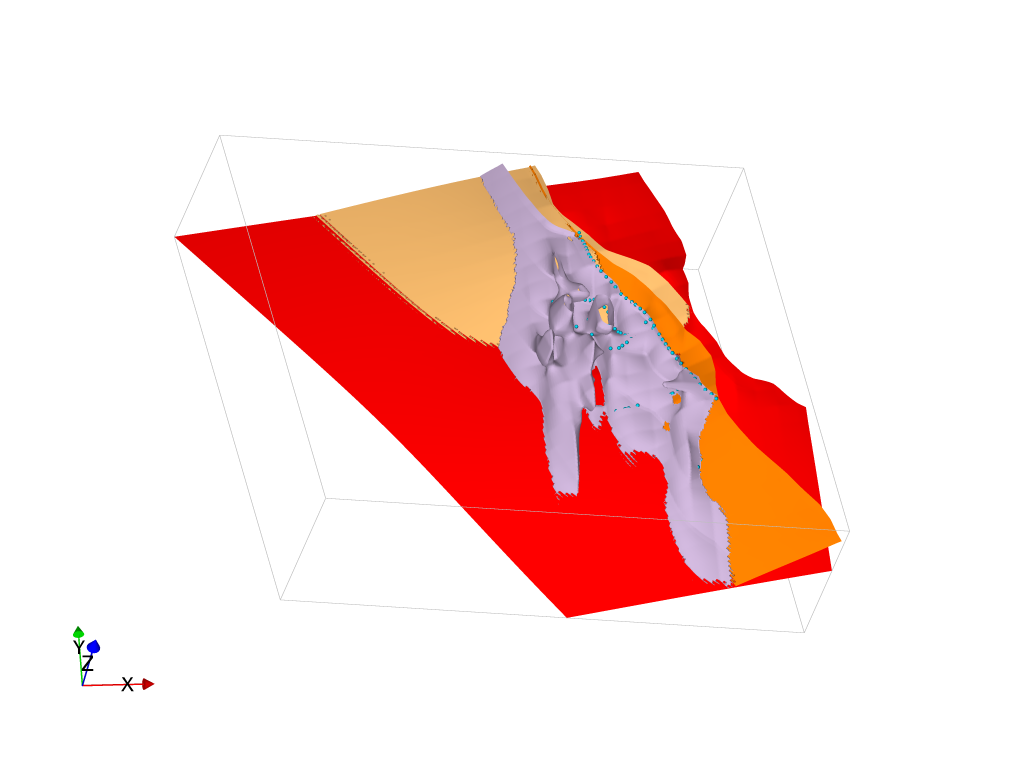

In [36]:
view = LavaVuModelViewer(model) 

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)

# view.add_points(BL_seismic[['X', 'Y', 'Z']], pointsize = 2, name = 'x')

view.add_data(model['Boulder Lefroy Fault'][0], )
# view.add_data(model['Kanowna Fault'][0])

# view.add_points(BL_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Kanowna_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')

view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

# view.interactive()

# version 2 of the seismic

In [37]:
updated_ori = updated_ori.reset_index(drop=True)

In [38]:
updated_ori = updated_ori.drop(updated_ori[updated_ori['fault_name']=='Boulder Lefroy Fault'].index)
updated_data = updated_data.drop(updated_data[updated_data['fault_name']=='Boulder Lefroy Fault'].index)

In [39]:
BL_pts = gpd.read_file(os.path.join(path_shp, "BL_pts_elevation_2.shp"))
BL_pts = pd.DataFrame({'X': BL_pts.geometry.x, 
              'Y': BL_pts.geometry.y, 
              'Z': BL_pts.DEM_main})

BL_pts['fault_name'] = "Boulder Lefroy Fault"

In [40]:
BL_seismic = gpd.read_file(os.path.join(path_seismic, "Boulder_Lefroy_cropped_v2.shp"))

BL_seismic = BL_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
BL_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

BL_seismic['fault_name'] = BL_seismic['fault_name'].str.replace('Boulder-Lefroy Shear Zone', "Boulder Lefroy Fault")

# drop the values above zero
BL_seismic = BL_seismic.drop(BL_seismic[BL_seismic['Z']>0].index)

In [41]:
gs = []

tmpA = []
tmpB = []

xs = BL_seismic['X'].to_numpy()
ys = BL_seismic['Y'].to_numpy()
zs = BL_seismic['Z'].to_numpy()

meanX = BL_pts['X'].mean()
meanY = BL_pts['Y'].mean()
meanZ = zs.max() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Boulder Lefroy Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [42]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])

In [43]:
updated_data = pd.concat([updated_data, BL_seismic, BL_pts])

In [44]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.nsteps = [100, 100, 250]

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False,cpw = 0.2,
                           regularisation = [5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 27.23387598991394 seconds


In [45]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])


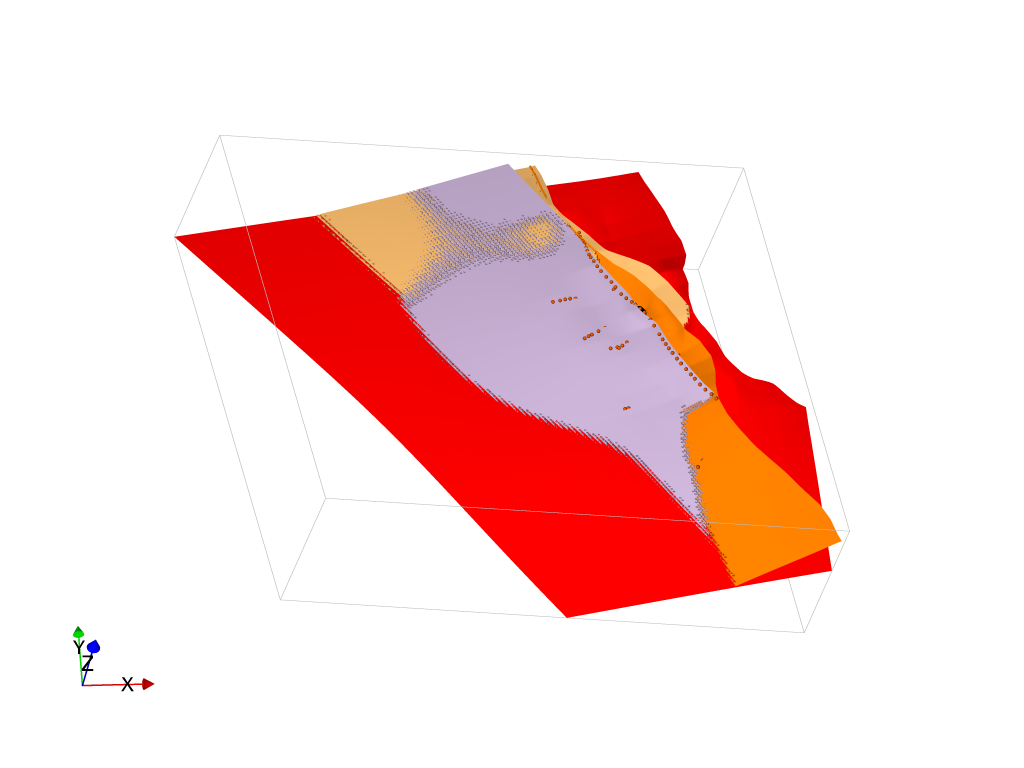

In [46]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)

# view.add_points(BL_seismic[['X', 'Y', 'Z']], pointsize = 2, name = 'x')

view.add_data(model['Boulder Lefroy Fault'][0], )
# view.add_data(model['Kanowna Fault'][0])

# view.add_points(BL_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Kanowna_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')

view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

# view.interactive()

# Add tangent constraints to the second version of the seismic

In [47]:
updated_ori = updated_ori.reset_index(drop=True)

In [48]:
updated_ori = updated_ori.drop(updated_ori[updated_ori['fault_name']=='Boulder Lefroy Fault'].index)

In [49]:
tangent_xy = (BL_pts[["X", "Y", "Z"]].to_numpy()[0, :] - BL_pts[["X", "Y", "Z"]].to_numpy()[-1, :])
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)

In [50]:
# find the maximum and minimum Z's
max_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()
min_xyz = BL_seismic[BL_seismic['Z']==BL_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()

In [51]:
tangent_z1 = (max_xyz - min_xyz)
norm_z = tangent_z1 / np.linalg.norm(tangent_z1) # unit vector

In [52]:
test_CP = np.cross(norm_xy, norm_z)

In [53]:
a = pd.DataFrame(test_CP)
a['fault_name'] = "Boulder Lefroy Fault"
a.columns = ['gx', 'gy', 'gz', 'fault_name']

In [54]:
a['X'] = BL_pts['X'].mean()
a['Y'] = BL_pts['Y'].mean()
a['Z'] = BL_seismic['Z'].mean()

In [55]:
updated_ori = pd.concat([updated_ori, a])

In [56]:
updated_ori

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853
1,Ida Fault,281825.127090,6.595975e+06,-19118.905000,0.455672,0.129275,0.865917
2,Bullabulling North Fault,288597.465546,6.618662e+06,-6250.689000,0.352245,0.102473,0.917071
3,Bulla_Abut_North,291113.118517,6.597520e+06,410.622447,0.000000,-0.996646,0.003071
4,Bullabulling South Fault,300390.029744,6.573092e+06,-6250.689000,0.352245,0.102473,0.917071
5,Bulla_Abut_South,298395.373188,6.581800e+06,404.589443,0.000000,0.043609,0.001308
6,Zuleika Fault,336167.443915,6.581425e+06,-3475.761250,-0.387965,-0.203100,-0.899018
7,MtMonger Fault,377066.123368,6.600121e+06,347.830000,0.380703,0.135495,-0.914716
8,Kanowna Fault,346826.424001,6.627378e+06,-6363.455172,0.199087,0.570989,-0.796452
9,Boorara Fault,360094.160551,6.592193e+06,-4751.938857,0.427567,0.191523,-0.883462


In [57]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

# model.nsteps = [100, 100, 250]

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cwp = 0.1, 
                          regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

# Force the tangents on BL Fault
tang2 = np.tile(tangent_z1[0],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 26.28266739845276 seconds


In [58]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])


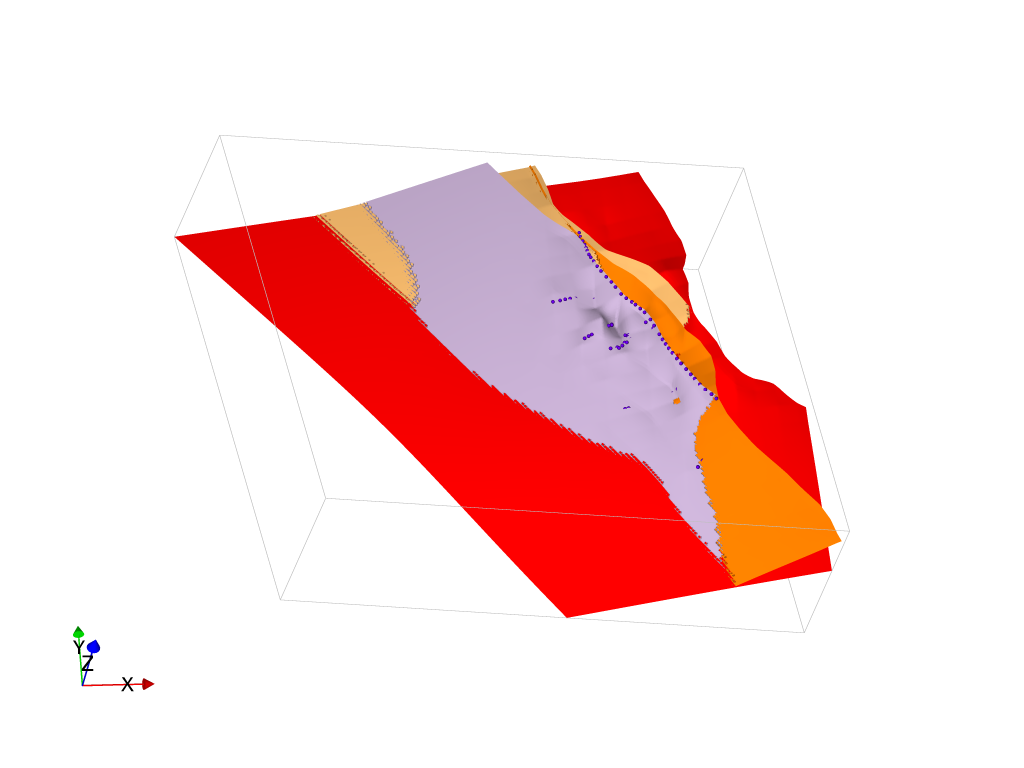

In [59]:
view = LavaVuModelViewer(model) 

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)

# view.add_points(BL_seismic[['X', 'Y', 'Z']], pointsize = 2, name = 'x')

view.add_data(model['Boulder Lefroy Fault'][0], )
# view.add_data(model['Kanowna Fault'][0])

# view.add_points(BL_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Kanowna_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')
# view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 2, pointcolour = 'green', name = 'x')

view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

# view.interactive()

# remove seismic entirely but keep ori obtained from seismic

In [60]:
updated_data = updated_data.reset_index(drop=True)

In [61]:
updated_data = updated_data.drop(updated_data[(updated_data['fault_name']=='Boulder Lefroy Fault')&
            (updated_data['Z']<0)].index)

In [62]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

# model.nsteps = [100, 100, 250]

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
                           #regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

# Force the tangents on BL Fault
tang2 = np.tile(tangent_z1[0],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 35.17029428482056 seconds


In [63]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])


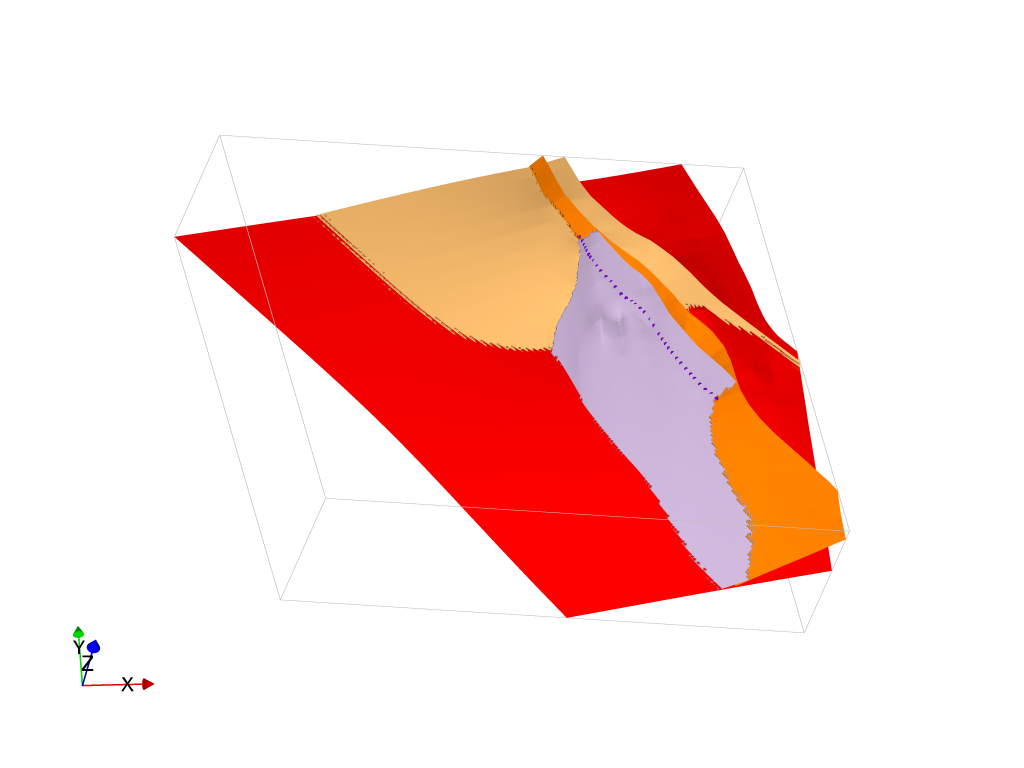

In [64]:
view = LavaVuModelViewer(model) 

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['red'], value = 0)

view.add_data(model['Boulder Lefroy Fault'][0], )

# view.zmax = 0.9
view.rotation = [-44.55155563354492, 21.535097122192383, -3.6014082431793213]
view.display()

### Add it all together

In [65]:
updated_ori[updated_ori['fault_name']=='Kunanalling Fault']

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853


In [66]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

# model.nsteps = [200, 200, 500]

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)
model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)
model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
                           #cwp = 0.1,
                           #npw = 0.05,
                           #regularisation=[5,5,5])
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])


#force the tangents over the fault trace points

# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# Force the tangents on BL Fault
tang2 = np.tile(tangent_z1[0],(model['Boulder Lefroy Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Boulder Lefroy Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Boulder Lefroy Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)


# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 33                     geological features that need to be interpolated



  0%|          | 0/33 [00:00<?, ?it/s]

Model update took: 59.30444288253784 seconds



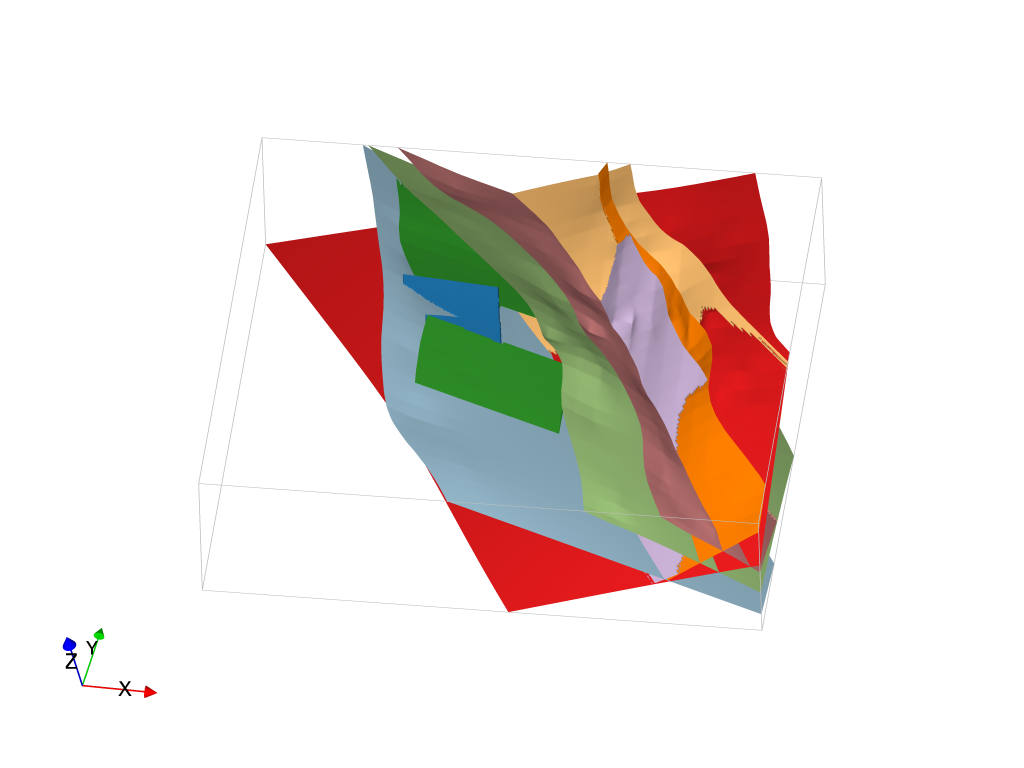

In [67]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)

# view.add_points(Kanowna_pts[['X', 'Y', 'Z']], name = 'Kanowna', pointsize = 5)

# view.interactive()

view.rotation = [-45.55978775024414, -6.185202598571777, -4.10226583480835]
view.display()

# Add abutting relationships

In [68]:
# Zuleika stops at BL (LINE2, LINE1)
# BOORARA STOPS AT BOULDER LEFROY (LINE 5)
# kunanalling - stopping at Zuleika, or BL, from line 5 seems to stop at BL 

In [69]:
model['Zuleika Fault'].add_abutting_fault(model['Boulder Lefroy Fault'])


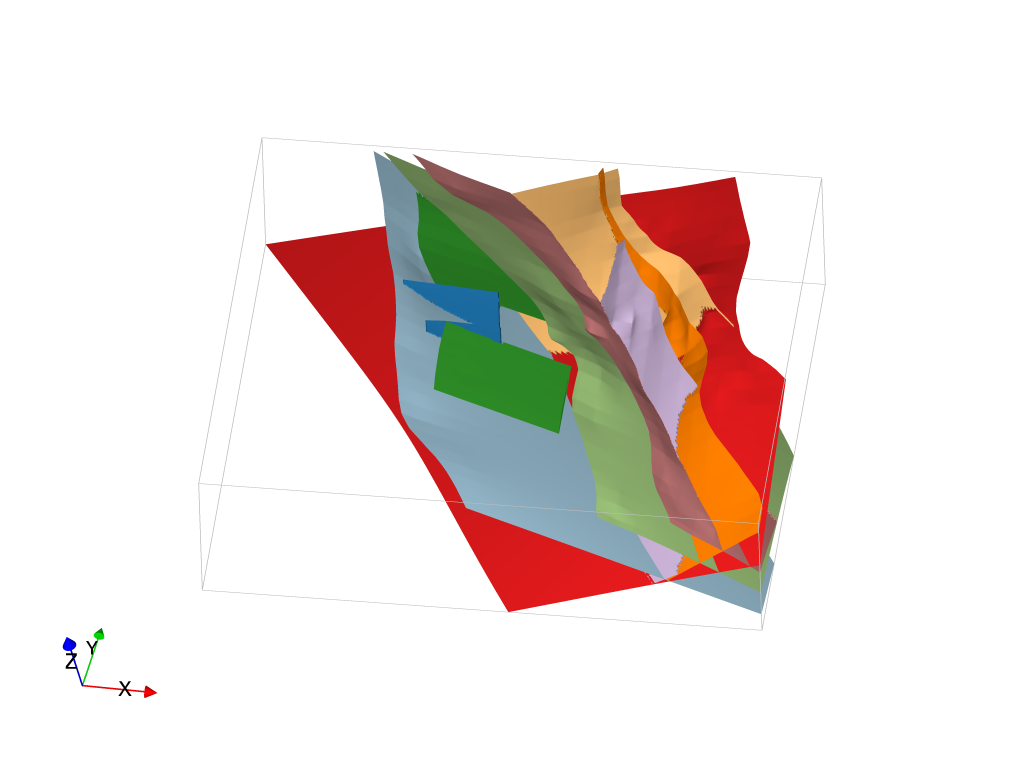

In [70]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)

# for fault_n in updated_ori['fault_name']:
#     view.add_data(model[fault_n][0])

# pts_files = [Ida_pts, Kunanalling_pts, Bull_N_pts, Bull_S_pts, Zuleika_pts, MtMonger_pts[['X', 'Y', 'Z']], 
#              Kanowna_pts[['X', 'Y', 'Z']], 
#                 Boorara_pts, BL_pts]
# pts_names = ['Ida_pts', 'Kunanalling_pts', 'Bull_N_pts', 'Bull_S_pts', 'Zuleika_pts', 'MtMonger_pts', 'Kanowna points', 
#                 'Boorara_pts', 'BL_pts']

# # for j, p in enumerate(pts_files):
# #     view.add_points(p, name = pts_names[j], pointsize = 5, colour = darken_color(color_list[j]))

# view.add_points(BL_seismic[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")
# view.add_points(BL_pts[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")

view.zmax = 0.95
# view.interactive()

view.rotation = [-45.55978775024414, -6.185202598571777, -4.10226583480835]
view.display()

In [71]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Boulder Lefroy Fault'].add_abutting_fault(model['Kanowna Fault'])


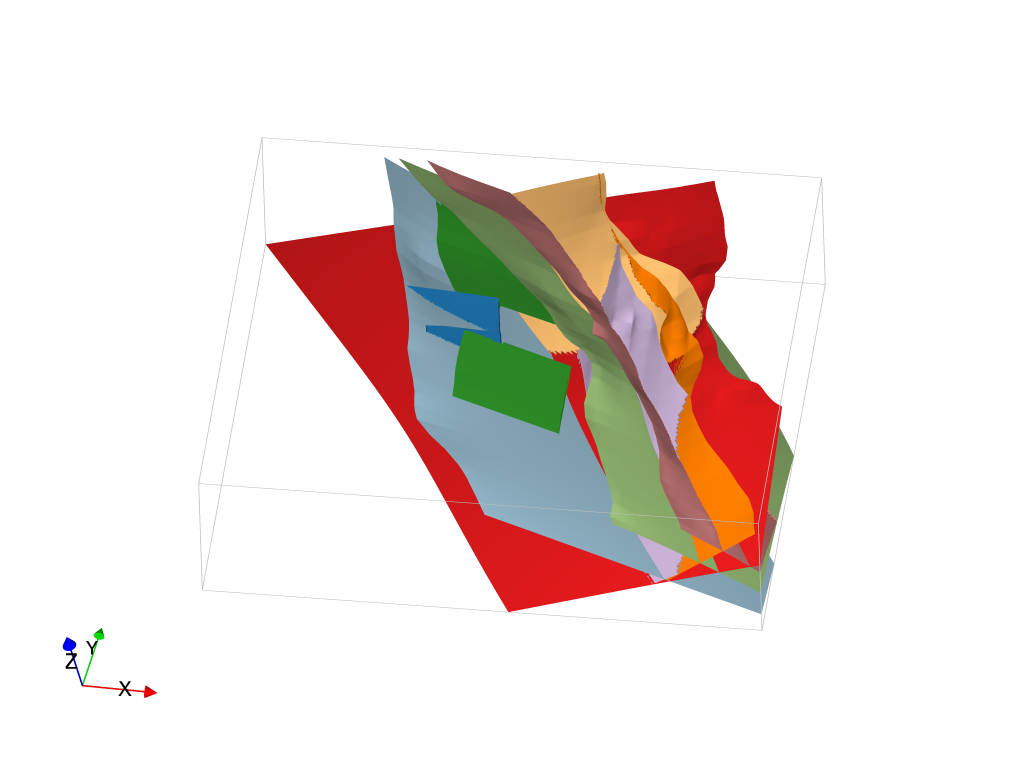

In [74]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)

# for fault_n in updated_ori['fault_name']:
#     view.add_data(model[fault_n][0])

# pts_files = [Ida_pts, Kunanalling_pts, Bull_N_pts, Bull_S_pts, Zuleika_pts, MtMonger_pts[['X', 'Y', 'Z']], 
#              Kanowna_pts[['X', 'Y', 'Z']], 
#                 Boorara_pts[['X', 'Y', 'Z']], BL_pts[['X', 'Y', 'Z']]]
# pts_names = ['Ida_pts', 'Kunanalling_pts', 'Bull_N_pts', 'Bull_S_pts', 'Zuleika_pts', 'MtMonger_pts', 'Kanowna points', 
#                 'Boorara_pts', 'BL_pts']

# for j, p in enumerate(pts_files):
#     view.add_points(p, name = pts_names[j], pointsize = 5, colour = darken_color(color_list[j]))

# view.add_points(BL_seismic[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")
# view.add_points(BL_pts[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")

view.zmax = 0.9
# view.interactive()

view.rotation = [-45.55978775024414, -6.185202598571777, -4.10226583480835]
view.display()